In [2]:
# CSCI441 Project
# SectionI: Code
# Made by Yousef Kahwaji, Ahmad Akoum, and Mohammad Al Dirani

In [3]:
import math

#recurring imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
#fetching dataset from yfinance
import yfinance as yf
nvda = yf.Ticker("NVDA")
df = nvda.history(period="max")
df.drop(columns=["Dividends",'Stock Splits'], inplace=True) #remove meaningless columns

In [5]:
#engineering meaningful columns. All engineered columns are explained in the report/ppt

from ta.momentum import RSIIndicator
from ta.trend import MACD

#SMA 20,50,100,200. Simple Moving Average.
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

#distance from trend, using sma
df['Close_SMA20_diff']  = df['Close'] / df['SMA_20'] - 1
df['Close_SMA50_diff']  = df['Close'] / df['SMA_50'] - 1
df['Close_SMA100_diff'] = df['Close'] / df['SMA_100'] - 1
df['Close_SMA200_diff'] = df['Close'] / df['SMA_200'] - 1

#RSI 14,30,90. Relative Strength Index. (momentum)
df['RSI14'] = RSIIndicator(close=df['Close'], window=14).rsi()
df['RSI30'] = RSIIndicator(close=df['Close'], window=30).rsi()
df['RSI90'] = RSIIndicator(close=df['Close'], window=90).rsi()

#rate of change. ROC. kinda momentum
df['ROC_5']  = df['Close'].pct_change(5)
df['ROC_10'] = df['Close'].pct_change(10)
df['ROC_20'] = df['Close'].pct_change(20)

#Volatility
df['Vol_5']  = df['Close'].pct_change().rolling(5).std()
df['Vol_10'] = df['Close'].pct_change().rolling(10).std()
df['Vol_20'] = df['Close'].pct_change().rolling(20).std()

#Price Structure (to prevent future leakage)
df['HL_range'] = (df['High'] - df['Low']) / df['Close']
df['OC_range'] = (df['Open'] - df['Close']) / df['Close']

#Trend confirmation
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

#Days and months for pattern recognition
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

#display all columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6778 entries, 1999-01-22 00:00:00-05:00 to 2025-12-31 00:00:00-05:00
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6778 non-null   float64
 1   High               6778 non-null   float64
 2   Low                6778 non-null   float64
 3   Close              6778 non-null   float64
 4   Volume             6778 non-null   int64  
 5   SMA_20             6759 non-null   float64
 6   SMA_50             6729 non-null   float64
 7   SMA_100            6679 non-null   float64
 8   SMA_200            6579 non-null   float64
 9   Close_SMA20_diff   6759 non-null   float64
 10  Close_SMA50_diff   6729 non-null   float64
 11  Close_SMA100_diff  6679 non-null   float64
 12  Close_SMA200_diff  6579 non-null   float64
 13  RSI14              6765 non-null   float64
 14  RSI30              6749 non-null   float64
 15  RSI90              6689 

In [6]:
#Finalizing the dataset for usage

#Creating Output with threshold to remove noise
df_2 = df.copy()
threshold = 0.005  # 0.5%
df_2['Change'] = np.where((df['Close'].shift(-1) / df['Close'] - 1) > threshold,'UP','DOWN')
df_2 = df_2.iloc[:-1] #removing the last row

#Removing the Close column
df_2.drop(columns=['Close'], inplace=True)

Default (Gini, Untuned)		
TrainTestSplit: 		49.38053097345133
KFold: 					50.53896308874593
Stratified KFold: 		52.146654475394314
Time Series Split: 		50.78830823737822

               precision    recall  f1-score   support

        DOWN       0.55      0.54      0.54       953
          UP       0.42      0.44      0.43       742

    accuracy                           0.49      1695
   macro avg       0.49      0.49      0.49      1695
weighted avg       0.50      0.49      0.49      1695



Entropy Tuned		
TrainTestSplit: 		49.616519174041294
KFold: 					51.04079722213151
Stratified KFold: 		48.88554354570094
Time Series Split: 		49.60141718334809

               precision    recall  f1-score   support

        DOWN       0.58      0.39      0.47       953
          UP       0.45      0.63      0.52       742

    accuracy                           0.50      1695
   macro avg       0.51      0.51      0.49      1695
weighted avg       0.52      0.50      0.49      1695



Gini Tun

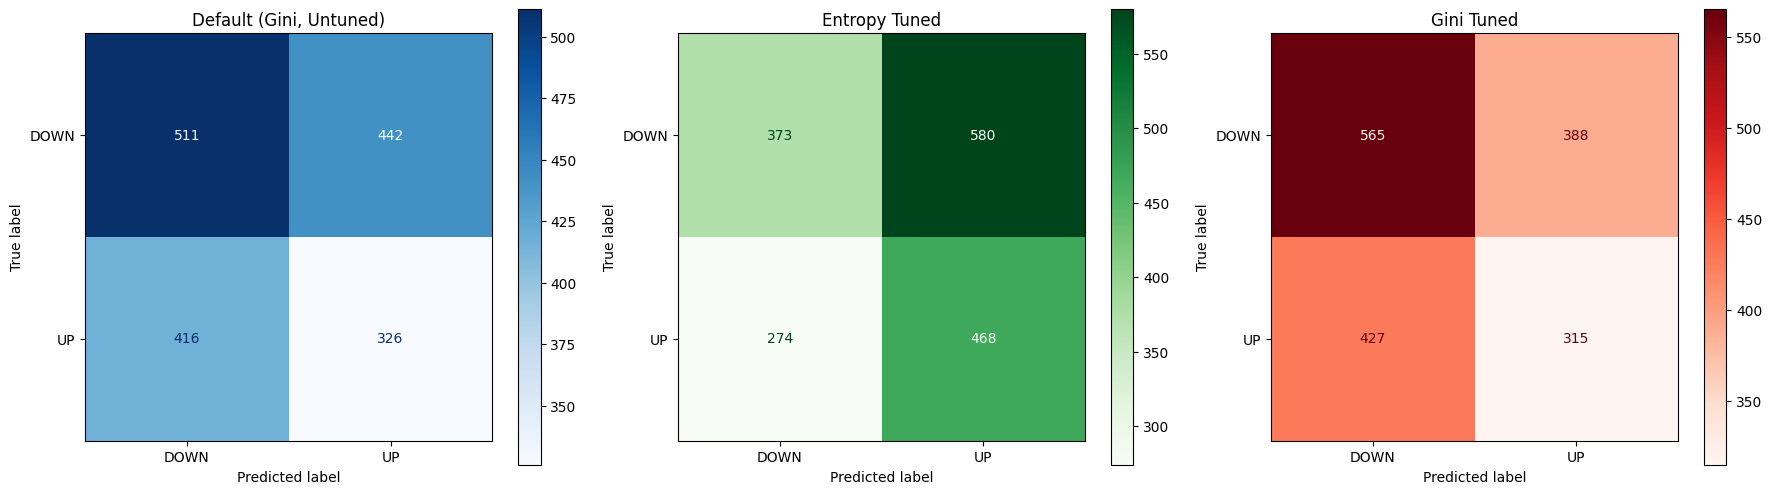

In [7]:
#Model 1: Decision Tree Classifier

#imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import ConfusionMatrixDisplay

#Preproc
#sklearn DTs do not require removing NaN values, can handle categorical output data, and are not sensitive to the scale of the input variables
#no dropna, no label encoding (the features are all linear in this case), and no standardization / normalization
#DT may require feature selection to avoid overfitting or Dimension Reduction.

X = df_2.drop(columns=['Change'])
y = df_2['Change']

#Data Splitting
X_train_tts, X_test_tts, y_train_tts, y_test_tts = train_test_split(X, y, test_size=0.25, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tss = TimeSeriesSplit(n_splits=5)

#Training, Testing, Evaluating
dtrees = [DecisionTreeClassifier(random_state=42), DecisionTreeClassifier(random_state=42, criterion='entropy', class_weight='balanced', max_depth=15), DecisionTreeClassifier(random_state=42, criterion='gini', class_weight='balanced', max_depth=17) ]
scores = []
reports = []
splitScores = {
    'KFold': [],
    'StratifiedKFold': [],
    'TimeSeriesSplit': []
}
predicts = []
labels = ['Default (Gini, Untuned)','Entropy Tuned','Gini Tuned']

for model in dtrees:
    model.fit(X_train_tts, y_train_tts)
    y_pred = model.predict(X_test_tts)
    predicts.append(y_pred)
    score = accuracy_score(y_test_tts, y_pred)
    report = classification_report(y_test_tts, y_pred)
    splitScores['KFold'].append(cross_val_score(model, X, y, cv=kf, scoring='accuracy'))
    splitScores['StratifiedKFold'].append(cross_val_score(model, X, y, cv=skf, scoring='accuracy'))
    splitScores['TimeSeriesSplit'].append(cross_val_score(model, X, y, cv=tss, scoring='accuracy'))
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nTrainTestSplit: " ,scores[i],end='\n', sep='\t\t')
    print("KFold: ",np.mean(splitScores['KFold'][i]*100),end='\n', sep='\t\t\t\t\t')
    print("Stratified KFold: ",np.mean(splitScores['StratifiedKFold'][i]*100),end='\n', sep='\t\t')
    print("Time Series Split: ",np.mean(splitScores['TimeSeriesSplit'][i]*100),end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(dtrees)):
    ConfusionMatrixDisplay.from_estimator(dtrees[i], X_test_tts, y_test_tts, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#The Decision Tree struggled, between 51% and 54% accuracy. Since 50% is a coin flip, these models aren't very dependable. This
#stayed true even when switching between the splits. The Entropy Tuned Model showed a high f1 balance, but had a 50% accuracy, which is not better than a coin
#flip, it is also highly volatile as shown by the precision and recall values. As for the Default Model, it had a higher accuracy than Entropy, however
#overall, the Gini Tuned Model proved to be the most accurate with a somewhat balanced precision and recall for up and down. Even so, this model still was
#biased towards DOWN and had a relatively low accuracy.
#Therefore, one Decision Tree is NOT suitable for this dataset, hence the next model.

Default (Gini, Untuned)		
TrainTestSplit: 		54.690265486725664

               precision    recall  f1-score   support

        DOWN       0.58      0.74      0.65       953
          UP       0.47      0.30      0.37       742

    accuracy                           0.55      1695
   macro avg       0.52      0.52      0.51      1695
weighted avg       0.53      0.55      0.52      1695



Entropy Tuned		
TrainTestSplit: 		51.62241887905604

               precision    recall  f1-score   support

        DOWN       0.57      0.60      0.58       953
          UP       0.44      0.41      0.42       742

    accuracy                           0.52      1695
   macro avg       0.50      0.50      0.50      1695
weighted avg       0.51      0.52      0.51      1695



Gini Tuned		
TrainTestSplit: 		51.62241887905604

               precision    recall  f1-score   support

        DOWN       0.59      0.47      0.52       953
          UP       0.46      0.58      0.51       742

    accu

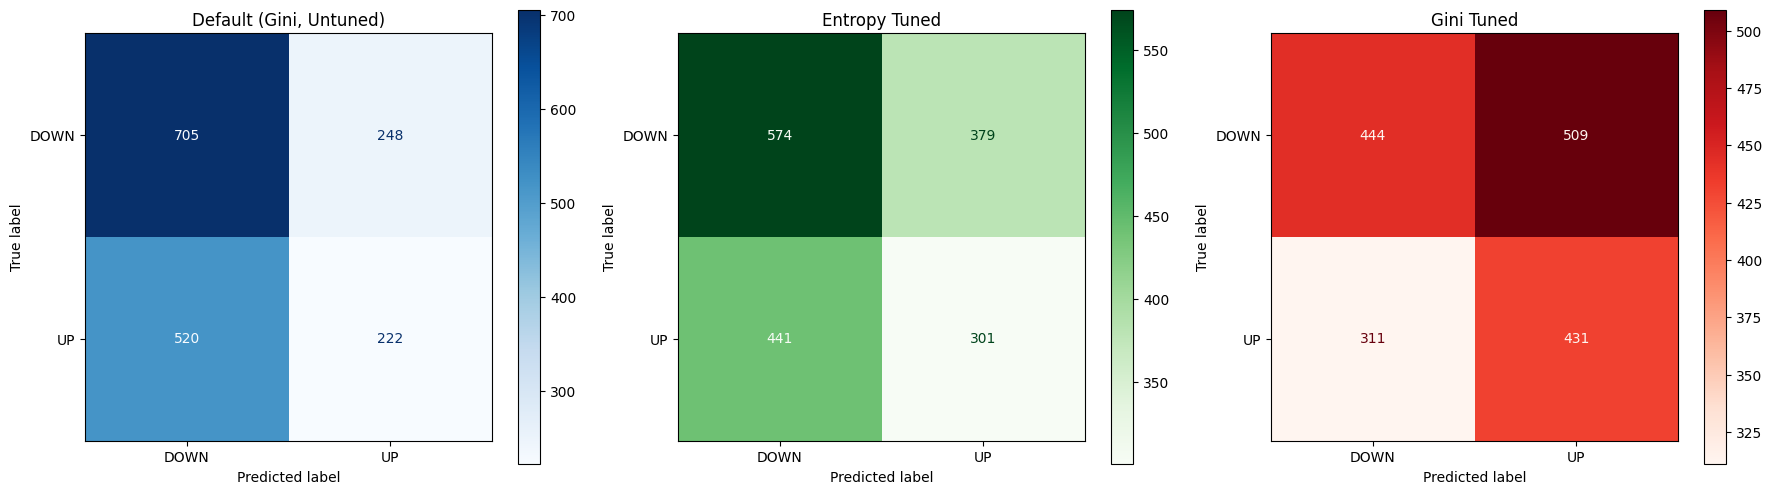

In [8]:
#Model 2: Random Forest
from sklearn.ensemble import RandomForestClassifier

#Preproc
#Identical to DT, none will be done. Same variables from dt will be used
#For the sake of saving run time, the other split methods will be removed (took approximately 6 minutes for each run when using multiple split methods)

#Training, Testing, Evaluating
rf=[RandomForestClassifier(random_state=42,n_estimators=200), RandomForestClassifier(random_state=42, criterion='entropy', class_weight='balanced', max_depth=10, n_estimators=150), RandomForestClassifier(random_state=42,criterion='gini',class_weight={'DOWN': 1, 'UP': 3.65},max_depth=20, n_estimators=1000)]

scores = []
reports = []
predicts = []

for model in rf:
    model.fit(X_train_tts, y_train_tts)
    y_pred = model.predict(X_test_tts)
    predicts.append(y_pred)
    score = accuracy_score(y_test_tts, y_pred)
    report = classification_report(y_test_tts, y_pred)
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nTrainTestSplit: " ,scores[i],end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(rf)):
    ConfusionMatrixDisplay.from_estimator(rf[i], X_test_tts, y_test_tts, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#The Random Forest models performed generally better than the Decision Tree models, yet they still struggled with accuracy, proving to also be an unsuitable choice for this dataset. While the untuned model had the highest accuracy, it had the worst balance, displaying heavy bias towards the DOWN as shown by the very low UP recall and precision values. As for the Tuned Entropy model, it tried to restore balance at the cost of accuracy, and only slightly succeeded. It had a 2% lower accuracy (avg) but was still relatively biased towards DOWN. Compared to the other models, the Tuned Gini model had the best balance by far, but the worst accuracy. It had almost no bias, making it more reliable than the others, but its accuracy is only slightly better than a coin flip.
#Therefore, the Tree and Ensemble models proved to be the wrong choice of models for this dataset, where the best possible one had only a slight increase over 50%, making it unreliable. More in depth analysis in the report.

KNN=3		
Accuracy: 		51.85410334346504

               precision    recall  f1-score   support

        DOWN       0.57      0.61      0.59       936
          UP       0.44      0.40      0.42       709

    accuracy                           0.52      1645
   macro avg       0.50      0.50      0.50      1645
weighted avg       0.51      0.52      0.52      1645



KNN=8		
Accuracy: 		53.799392097264445

               precision    recall  f1-score   support

        DOWN       0.58      0.66      0.62       936
          UP       0.46      0.37      0.41       709

    accuracy                           0.54      1645
   macro avg       0.52      0.52      0.52      1645
weighted avg       0.53      0.54      0.53      1645



KNN=Sqrt of length		
Accuracy: 		56.59574468085107

               precision    recall  f1-score   support

        DOWN       0.58      0.88      0.70       936
          UP       0.49      0.15      0.23       709

    accuracy                           0.57 

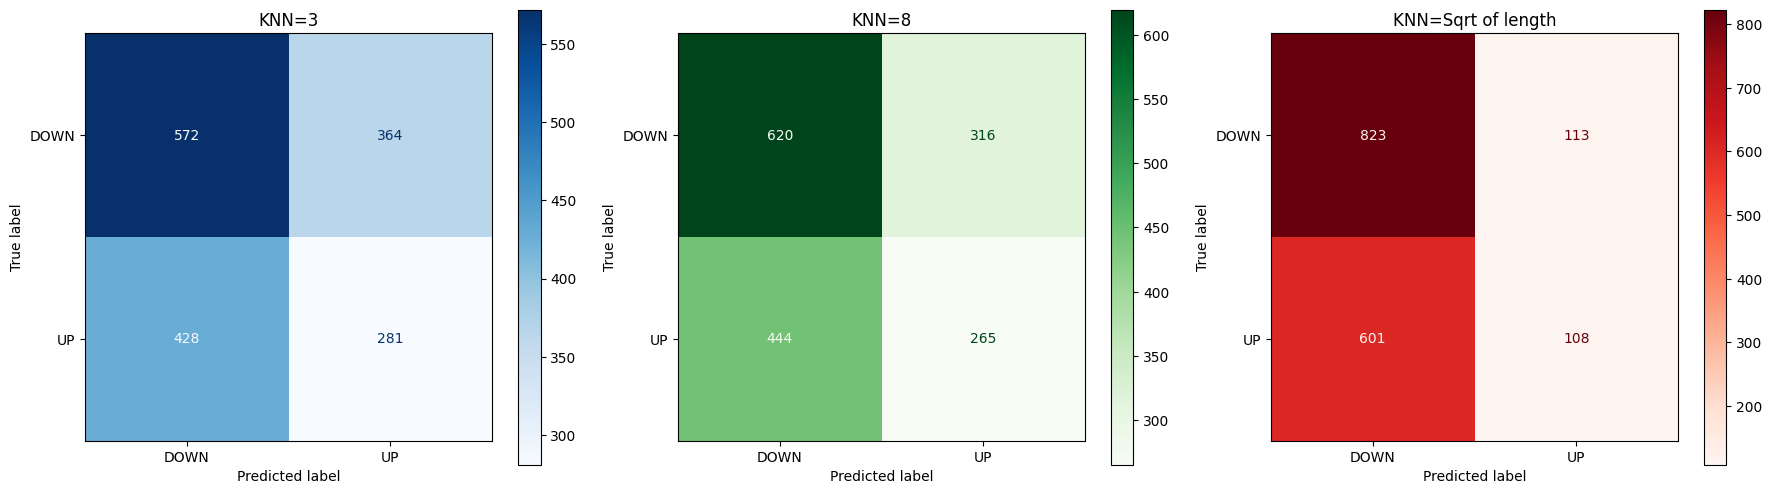

In [9]:
#Model 3: K-Nearest Neighbors
#(Can't use Naive Bayes due to the assumption of independence)

#Preproc
# KNN requires removing null values
dfKnn = df_2.copy().dropna()
X = dfKnn.drop(columns=['Change'])
y = dfKnn['Change']

# KNN doesn't work well with high number of features, so we need to do dimension reduction. PCA in this case. Also, KNN requires scaling
#   1. splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#   2. scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#   3. pca
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# As for outliers, this dataset doesn't actually have any outliers. Any large increases or decreases are meant to be kept and not removed

#Training, Testing, and Evaluating
from sklearn.neighbors import KNeighborsClassifier
import math
knn = [KNeighborsClassifier(weights='distance',n_neighbors=3), KNeighborsClassifier(weights='distance',n_neighbors=8), KNeighborsClassifier(weights='distance',n_neighbors=math.ceil(math.sqrt(len(X_train))))]
labels = ['KNN=3','KNN=8', 'KNN=Sqrt of length']
predicts = []
scores = []
reports = []

for model in knn:
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    predicts.append(y_pred)
    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nAccuracy: " ,scores[i],end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(knn)):
    ConfusionMatrixDisplay.from_estimator(knn[i], X_test_pca, y_test, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#KNN struggled with this dataset, proving once more how difficult this prediction is. The Sqrt of length model had the highest accuracy between the 3 models, and even higher than the tree and ensemble models, but it had a shockingly low recall for UP (15%), this means that this model is most likely lazy and going for the easy approach of choosing DOWN almost always. This is backed up even more by its Confusion Matrix, where we see that it didn't even predict that many UPs compared to down. As for the N=3 model, its balance wasn't too bad, however its accuracy is only 1% better than a coin flip. Finally, the N=8 model as expected ended up in the middle, with accuracy of ~54% and a lower balance than the first model.
#Overall this model seems to generally struggle between balance and accuracy, sacrificing one for the other as the K changes. It seems no matter what that number is, the previous models still were generally better than KNN, proving that this model is not suitable for this dataset.